**Instruktioner**

Du ska nu experimentera med Q-learning för ett miniproblem ”Cart-pole” och försöka få den inverterade pendeln på en vagn att stå upp så länge som möjligt.

Plotta hur mycket belöning systemet får för varje episod för att se hur systemet beter sig över tid? Vilka 4 mätvärden ingår i tillståndsinformationen som är grund för om man ska putta vagnen till höger eller vänster? Gör gärna fler experiment med samma parameteruppsättning för att också få en känsla för hur stabila resultaten är. En sammanlagd reward, dvs hur många steg som systemet lyckas få pinnen att fortsätta stå upp, på mer än 180 räknas som mycket bra.

Testa med några olika parametervärden, t ex öka antalet episoder för att få en känsla för när resultaten börjar stabilisera sig; öka/minska inlärningstakten; eller t.o.m. öka kvantifieringen av tillståndsrymden (men inte för mycket då det ju gör Q-tabellen rejält mycket större för varje steg). Även Epsilon, som styr hur girig (exploit) den ska vara att ta ett slumpmässigt beslut för sin ”action” kan vara intressant att experimentera med.

För att bättre förstå, de troligen mediokra resultaten, ska du även undersöka Q-tabellen efter träningen. Hur mycket av “världen” har systemet utforskat? Vad säger detta om Q-learning som metod och kan du komma på något som skulle förbättra systemets prestanda och stabilitet.

Med en anpassning av epsilon och inlärningshastighet över tid (börja högt för att möjliggöra mer utforskning och inlärning till en början och sedan senare minska värdet för att stabilisera) kan förbättra prestandan avsevärt. Se Geron Kapitel 18 "exploration policies". Implementera detta (är kanske 4-5 rader kod!) för att se om det hjälper, men se till att jämföra med fallet då dessa parametrar är oföränderliga.

**Historik**
* 2020-05-06 Initial version /ToNo
* 2020-05-07 Uppdaterade instruktionerna (ersatte fjolårets som glömts kvar) /ToNo
* 2020-12-07 Ersatte argmax med en biblioteksfunktion /ToNo
* 2022-12-16 Uppdaterade koden för att stödja ett nytt gym API /ToNo
* 2022-12-27 Bättre stöd för olika gym versioner /ToNo


# Set up the Colab environment

In [ ]:
import sys

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

# Helper libraries
import os
import numpy as np
from numpy import argmax
import time

# Matlab plotting
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
# To plot pretty figures
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow version: 2.17.1
Keras version: 3.5.0


In [ ]:
# Replace OpenAI gym with gymnasium
# https://farama.org/Announcing-The-Farama-Foundation
# https://github.com/Farama-Foundation/Gymnasium
# https://younis.dev/blog/render-api/

if (IS_COLAB or IS_KAGGLE):
  !pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 9.1 MB/s eta 0:00:00


In [ ]:
# For this Lab
import random
import gymnasium as gym

In [ ]:
# Test for GPU and determine what GPU we have
# Could also use https://github.com/anderskm/gputil
import sys
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Select a GPU hardware accelerator.")
else:
    !nvidia-smi -L

No GPU was detected. CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# The Main RL Code ##

In [ ]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)


In [ ]:
# Inspired by RL researchers and written by Kalle Prorok for a Deep Learning Course
# Umeå Sweden 2019

# A set of parameters that is working well
EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 10     # discretization steps per state variable (avoid odd numbers), org val = 10

# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state


In [ ]:
# Create the Gym environment (CartPole)
env = gym.make('CartPole-v1')
observation = env.reset(seed=42) # seed it to something known

In [ ]:
# (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
average_cumulative_reward = 0.0

episode_reward = np.zeros(EPISODES)

print('Action space is:', env.action_space)
print('Observation space is:', env.observation_space)

# Q-table for the discretized states, and two actions
num_states = DISCRETE_STEPS ** 4
qtable = [[0., 0.] for state in range(num_states)]
print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

# Loop over episodes
start = time.time()
for i in range(EPISODES):
    state4D, *_ = env.reset()
    state = make_state(state4D)

    terminate = False
    cumulative_reward = 0.0

    # Loop over time-steps
    while not terminate:
        # Compute what the greedy action for the current state is
        qvalues = qtable[state]
        greedy_action = argmax(qvalues)

        # Sometimes, the agent takes a random action, to explore the environment
        if random.random() < EPSILON:
            action = random.randrange(2)
        else:
            action = greedy_action

        # Perform the action
        next_state, reward, terminate, *_ = env.step(action)  # truncated & info is ignored
        next_state = make_state(next_state)

        # Update the Q-Table
        td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
        qtable[state][action] += LEARNING_RATE * td_error
        # Update statistics
        cumulative_reward += reward
        state = next_state

    # store reward for every episode
    episode_reward[i] = cumulative_reward

    # Adapt epsilon and learning rate here

    # Per-episode statistics
    if ((i % 500)==0):
      print(i, cumulative_reward, sep=',')

end = time.time()
print(f"\nTime to run: {end - start:.1f}",)

Action space is: Discrete(2)
Observation space is: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Q-table = 10000 x 2
0,10.0
500,26.0
1000,10.0
1500,10.0
2000,10.0
2500,30.0
3000,17.0
3500,16.0
4000,12.0
4500,9.0
5000,10.0
5500,9.0
6000,45.0
6500,11.0
7000,27.0
7500,45.0
8000,23.0
8500,39.0
9000,26.0
9500,25.0
10000,13.0
10500,18.0
11000,14.0
11500,13.0
12000,13.0
12500,55.0
13000,27.0
13500,28.0
14000,52.0
14500,14.0

Time to run: 31.3


# Analysis...
Try a number of parameter settings and try to get stable and good performance. Do not dispare if the results seems poor, it is very tricky to get good results!  

(0.0, 500.0)

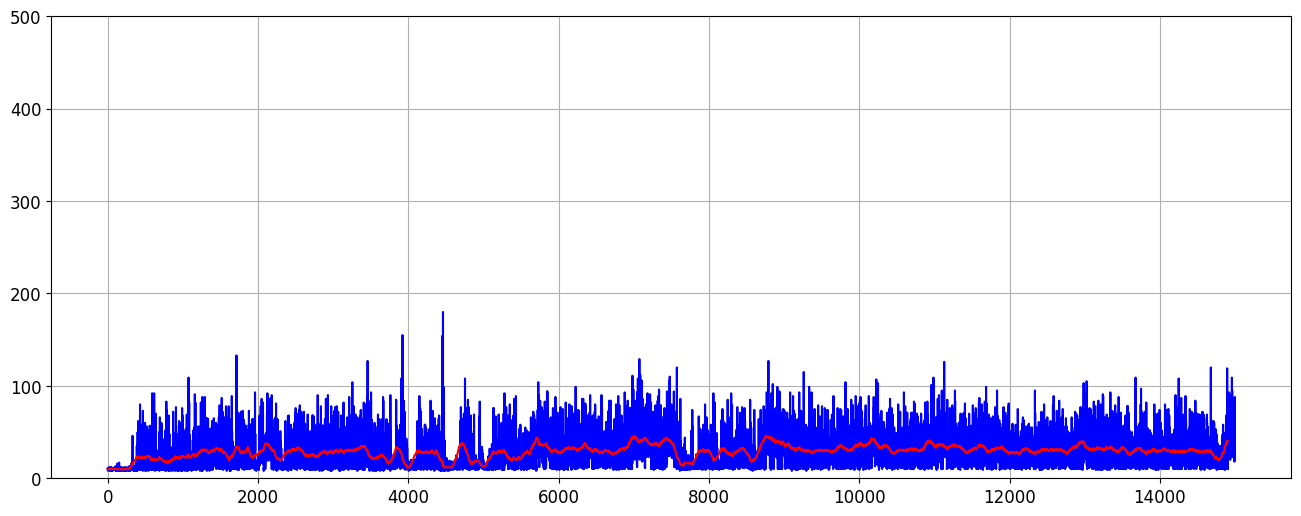

In [ ]:
# Plot the results from a training run
fig, ax = plt.subplots(figsize=(16, 6))
ax.grid()
ax.plot(episode_reward,"b")
y_av = running_mean(episode_reward, N=100)
ax.plot(y_av,"r")
ax.set_ylim(0, 500)

# Continued Analysis
To better understand why the performance is so poor, you should check how much of the Q-table is filled in (corresponding to how much of the environment that is explored). What part of the Q-table is filled in? What conclusions can we make out of this?

With an adaptation of epsilon and learning rate (starting high to allow for more exploration and learning in the beginning, and then later reduce the value) can significantly improve the performance. See Geron's "exploration policies".

In [ ]:
def make_state(observation):
    """ Map a 4-dimensional state into a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state

def evaluate_q_table(qtable):
    visited_states = sum([1 for q in qtable if max(q) != 0])
    fill_rate = visited_states / len(qtable)
    print(f"Q-table visited states: {visited_states}/{len(qtable)}")
    print(f"Exploration rate: {fill_rate:.2%}")


In [ ]:
def train_agent(EPISODES, EPSILON, GAMMA, LEARNING_RATE, DISCRETE_STEPS, PRINT):
    '''
        trains the agent for the given parameters
        and returns the Q-table and the episode rewards
    '''
    # Initialise statistics to zero
    average_cumulative_reward = 0.0
    episode_reward = np.zeros(EPISODES)

    # Q-table for the discretized states, and two actions
    num_states = DISCRETE_STEPS ** 4
    qtable = [[0., 0.] for state in range(num_states)]
    print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

    # Loop over episodes
    for i in range(EPISODES):
        state4D, _ = env.reset()
        state = make_state(state4D)

        done = False
        cumulative_reward = 0.0

        # Loop over time-steps
        while not done:
            # Compute what the greedy action for the current state is
            qvalues = qtable[state]
            greedy_action = argmax(qvalues)


            # Sometimes, the agent takes a random action, to explore the environment
            if random.random() < EPSILON:
                action = random.randrange(2)
            else:
                action = greedy_action

            # Perform the action
            obs, reward, terminate, truncated, _ = env.step(action)  # info is ignored
            next_state = make_state(obs)

            # Update the Q-Table
            td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
            qtable[state][action] += LEARNING_RATE * td_error

            # Update statistics
            cumulative_reward += reward
            state = next_state

            done = terminate or truncated

        # store reward for every episode
        episode_reward[i] = cumulative_reward

        EPSILON = max(0.01, EPSILON * 0.999)
        LEARNING_RATE = max(0.01, LEARNING_RATE * 0.999)

        # Per-episode statistics
        if ((i % 500)==0 and PRINT):
            print(i, cumulative_reward, sep=',')

    return qtable, episode_reward

In [ ]:
def plot_reward(episode_reward):
    '''
        plots episode reward along with
        the running episode mean
    '''
    plt.figure(figsize=(16, 4))
    plt.plot(episode_reward,"b")
    y_av = running_mean(episode_reward, N=100)
    plt.plot(y_av,"r")
    plt.show()


# Vary number of episodes

Number of episodes: 10000
Q-table = 20736 x 2
Q-table visited states: 188/20736
Exploration rate: 0.91%


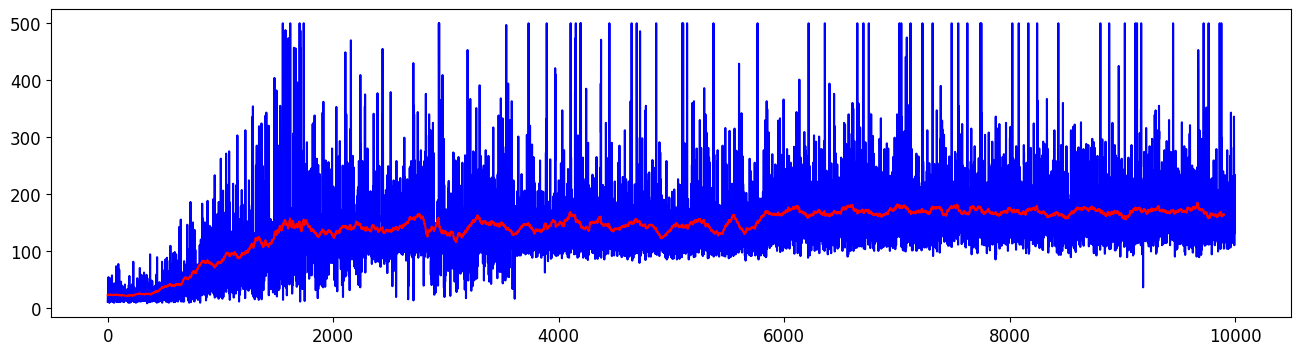

Number of episodes: 15000
Q-table = 20736 x 2
Q-table visited states: 196/20736
Exploration rate: 0.95%


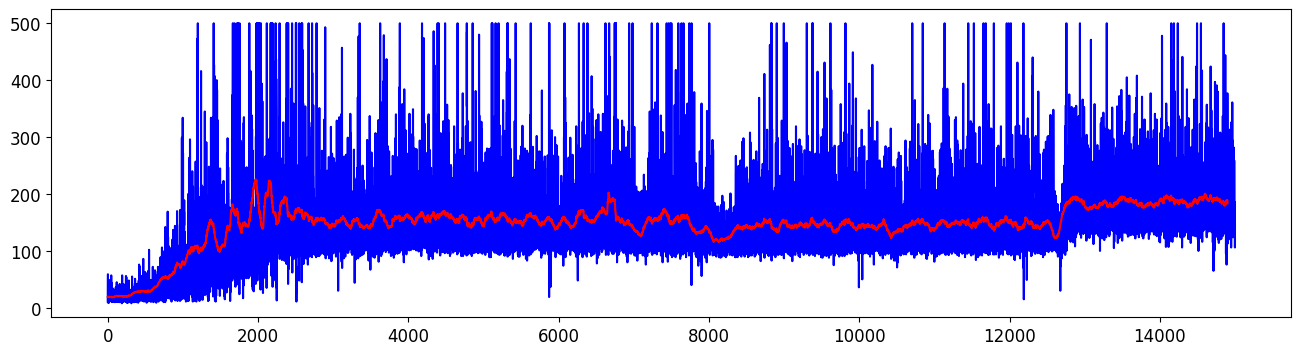

Number of episodes: 20000
Q-table = 20736 x 2
Q-table visited states: 203/20736
Exploration rate: 0.98%


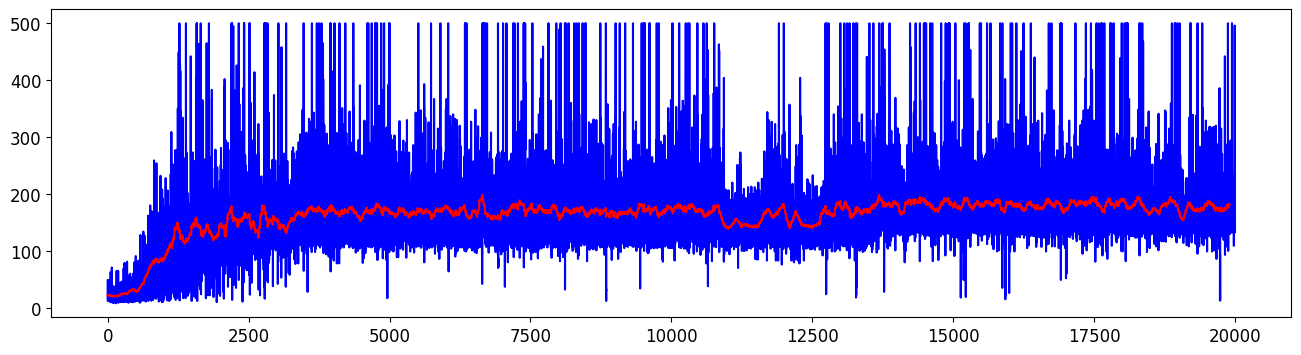

Number of episodes: 25000
Q-table = 20736 x 2
Q-table visited states: 194/20736
Exploration rate: 0.94%


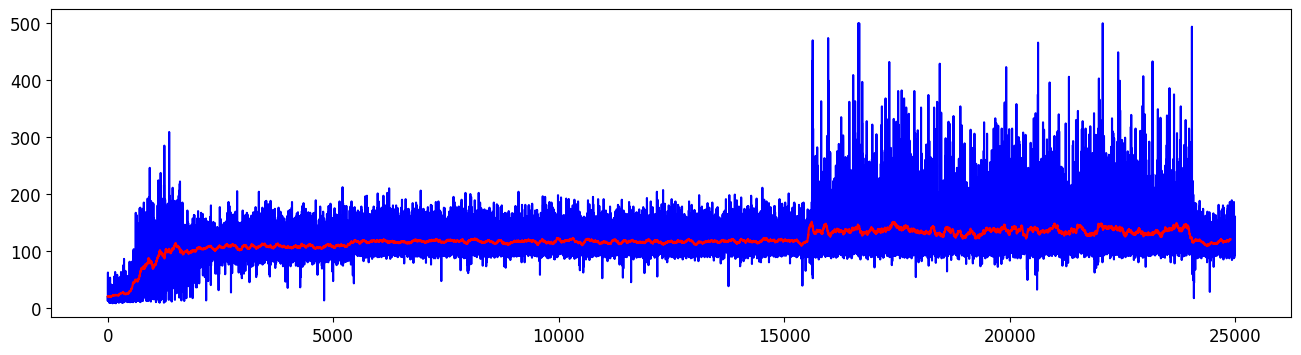

In [ ]:
EPISODES       = [10000, 15000, 20000, 25000]  # Number of eposides to run, org. val = 15000
EPSILON        = 1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # Discretization steps per state variable (aviod odd numbers), org val = 10
PRINT          = False  # Determine if cumulative episode rewards should be printed


for episode in EPISODES:
    print('Number of episodes: {}'.format(episode))
    q, r = train_agent(episode, EPSILON, GAMMA, LEARNING_RATE, DISCRETE_STEPS, PRINT)
    evaluate_q_table(q)
    plot_reward(r)


| **Episodes**       | **Exploration Rate (EPSILON=0.1)** | **Exploration Rate (EPSILON=1)** | **Visited States (Before)** | **Visited States (After)** |
|---------------------|-----------------------------|-----------------------------|-----------------------------|----------------------------|
| **10,000**         | 0.26%                       | 0.91%                       | 53 / 20,736                 | 188 / 20,736               |
| **15,000**         | 0.30%                       | 0.95%                       | 63 / 20,736                 | 196 / 20,736               |
| **20,000**         | 0.15%                       | 0.98%                       | 32 / 20,736                 | 203 / 20,736               |
| **25,000**         | 0.29%                       | 0.94%                       | 60 / 20,736                 | 194 / 20,736               |

1. **Exploration Rate Improvement**:  
   - By starting **epsilon at 1.0** and implementing a slower decay (`0.999`), the exploration rate increased significantly (from **~0.3%** to **~0.95%**).  
   - The number of visited states increased from a maximum of **63** (before) to **203** (after).  
   - However, exploration is still far from complete, as the Q-table has **20,736 states**, and less than 1% of them were visited.

2. **Performance Improvement**:  
   - The reward plots indicate more stable rewards after the adjustment. Early exploration allowed the agent to discover better policies, as seen in the smoother and higher red line (average reward) in later episodes.  
   - Before adjustments, the agent's performance early due to insufficient exploration.

3. **State Space Issue**:  
   - The large state space (20,736 x 2) remains a bottleneck. Even with improved exploration, the agent cannot visit enough states to learn an optimal policy effectively within the given episodes.  

- **Before Adjustments**:  
   - Exploration was inadequate (low epsilon, fast decay), leading to poor state coverage and suboptimal performance.

- **After Adjustments**:  
   - Improved exploration significantly increased the visited states and stabilized performance.  
   - However, the state space is too large, and less than **1% of states** were explored even after 25,000 episodes.

# Vary number of GAMMA

In [ ]:
EPISODES       = 15000  # Number of eposides to run, org. val = 15000
EPSILON        = 1   # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = [0.5, 0.75, 0.9]    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # Discretization steps per state variable (aviod odd numbers), org val = 10
PRINT          = False  # Determine if cumulative episode rewards should be printed

Value of gamma: 0.5
Q-table = 20736 x 2
Q-table visited states: 184/20736
Exploration rate: 0.89%


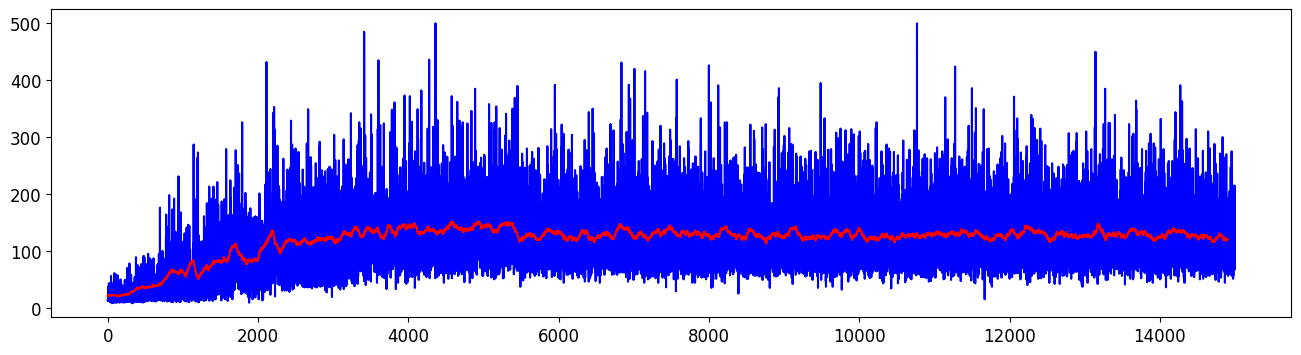

Value of gamma: 0.75
Q-table = 20736 x 2
Q-table visited states: 206/20736
Exploration rate: 0.99%


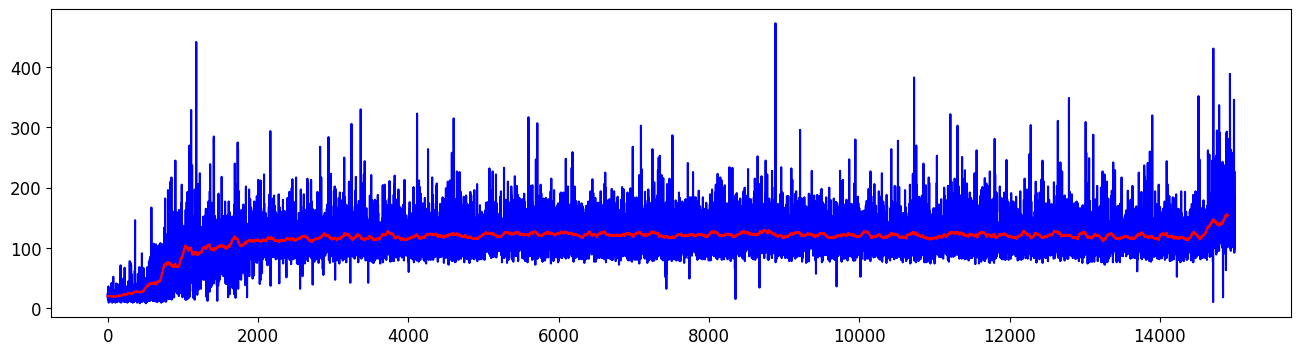

Value of gamma: 0.9
Q-table = 20736 x 2
Q-table visited states: 227/20736
Exploration rate: 1.09%


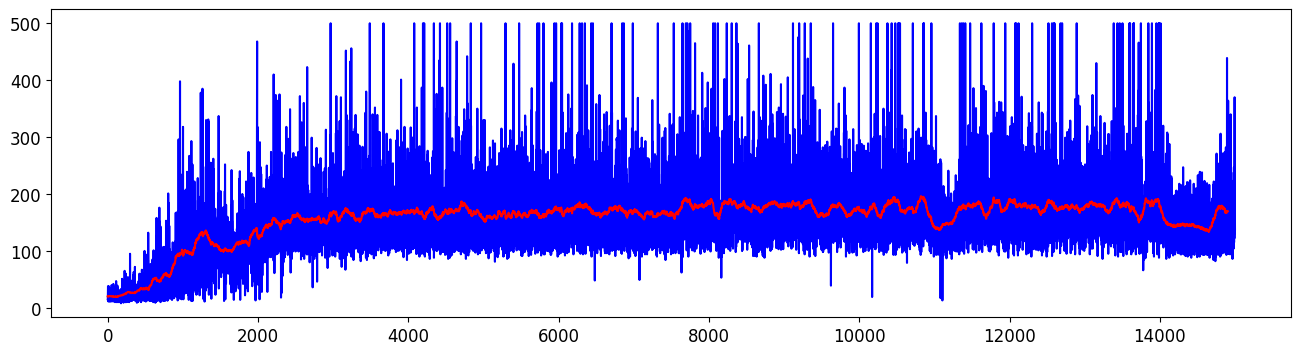

In [ ]:
for gamma in GAMMA:
    print('Value of gamma: {}'.format(gamma))
    q, r = train_agent(EPISODES, EPSILON, gamma, LEARNING_RATE, DISCRETE_STEPS, PRINT)
    evaluate_q_table(q)
    plot_reward(r)

1. **Exploration Rate**:  
   - In the **previous run**, where EPSILON was set to **0.1**, the exploration rate was very low (**0.20%-0.26%**) due to limited random actions.  
   - In the **current run**, starting with **EPSILON = 1.0** significantly improved exploration (**0.89%-1.09%**), leading to better state coverage.  

2. **Visited States**:  
   - The number of visited states increased from **~54** to **~185-226** out of **20,736** possible states.  
   - This is a clear improvement, showing that higher EPSILON encourages exploration early in training.

3. **Effect of GAMMA**:  
   - Different **GAMMA values** (0.5, 0.75, 0.9) influence the way rewards propagate over time:  
     - Lower GAMMA (0.5): Focuses on short-term rewards.  
     - Higher GAMMA (0.9): Considers long-term rewards.  
   - However, the exploration rate primarily depends on **EPSILON**, and GAMMA mainly impacts reward optimization rather than state exploration.

The current run, with **EPSILON = 1.0**, achieved better exploration (0.89%-1.09%) compared to the previous run (0.20%-0.26%). However, the state space remains largely unexplored due to its size. Further adjustments to EPSILON decay, state space reduction, and training duration are needed to improve performance.